## T5 Model Version and Tokenizer

In [18]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

### Version

In [19]:
CKPT = 't5-base'

### Model and Tokenizer

In [22]:
model = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer = AutoTokenizer.from_pretrained(CKPT)

loading configuration file config.json from cache at C:\Users\Huang/.cache\huggingface\hub\models--t5-base\snapshots\0db7e623bcaee2daf9b859a646637ea39bf016cd\config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
 

## Data Loading and Preprocessing

In [ ]:
from datasets import load_dataset

### Loading

In [31]:
train_dataset = load_dataset('wikisql', split='train+validation')
test_dataset = load_dataset('wikisql', split='test')

### Exploration

In [43]:
train_dataset[0]

{'phase': 1,
 'question': 'Tell me what the notes are for South Australia ',
 'table': {'header': ['State/territory',
   'Text/background colour',
   'Format',
   'Current slogan',
   'Current series',
   'Notes'],
  'page_title': '',
  'page_id': '',
  'types': ['text', 'text', 'text', 'text', 'text', 'text'],
  'id': '1-1000181-1',
  'section_title': '',
  'caption': '',
  'rows': [['Australian Capital Territory',
    'blue/white',
    'Yaa·nna',
    'ACT · CELEBRATION OF A CENTURY 2013',
    'YIL·00A',
    'Slogan screenprinted on plate'],
   ['New South Wales',
    'black/yellow',
    'aa·nn·aa',
    'NEW SOUTH WALES',
    'BX·99·HI',
    'No slogan on current series'],
   ['New South Wales',
    'black/white',
    'aaa·nna',
    'NSW',
    'CPX·12A',
    'Optional white slimline series'],
   ['Northern Territory',
    'ochre/white',
    'Ca·nn·aa',
    'NT · OUTBACK AUSTRALIA',
    'CB·06·ZZ',
    'New series began in June 2011'],
   ['Queensland',
    'maroon/white',
    'nnn·aaa

In [48]:
def format_eda_dataset(example):
    return {'input': example['question'], 'target': example['sql']['human_readable']}
eda_dataset = train_dataset.map(format_eda_dataset, remove_columns=train_dataset.column_names)

In [47]:
eda_dataset[0]

{'input': 'Tell me what the notes are for South Australia ',
 'target': 'SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA'}

In [49]:
# map article and summary len to dict as well as if sample is longer than 512 tokens
def map_to_length(x):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('t5-base')
    x["input_len"] = len(tokenizer(x["input"]).input_ids)
    x["input_longer_256"] = int(x["input_len"] > 256)
    x["input_longer_128"] = int(x["input_len"] > 128)
    x["input_longer_64"] = int(x["input_len"] > 64)
    x["out_len"] = len(tokenizer(x["target"]).input_ids)
    x["out_longer_256"] = int(x["out_len"] > 256)
    x["out_longer_128"] = int(x["out_len"] > 128)
    x["out_longer_64"] = int(x["out_len"] > 64)
    return x

sample_size = 10000
data_stats = eda_dataset.select(range(sample_size)).map(map_to_length, num_proc=4)


Map (num_proc=4):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [54]:
print(
    "Input Mean: {} \n%-Input > 256:{} \n%-Input > 128:{} \n%-Input > 64:{} \nOutput Mean:{} \n%-Output > 256:{} \n%-Output > 128:{} \n%-Output > 64:{}".format(
        sum(data_stats["input_len"]) / sample_size,
        sum(data_stats["input_longer_256"]) / sample_size,
        sum(data_stats["input_longer_128"]) / sample_size,
        sum(data_stats["input_longer_64"]) / sample_size,   
        sum(data_stats["out_len"]) / sample_size,
        sum(data_stats["out_longer_256"]) / sample_size,
        sum(data_stats["out_longer_128"]) / sample_size,
        sum(data_stats["out_longer_64"]) / sample_size,
    )
)

Input Mean: 15.8508 
%-Input > 256:0.0 
%-Input > 128:0.0 
%-Input > 64:0.0001 
Output Mean:20.0403 
%-Output > 256:0.0 
%-Output > 128:0.0002 
%-Output > 64:0.0005


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

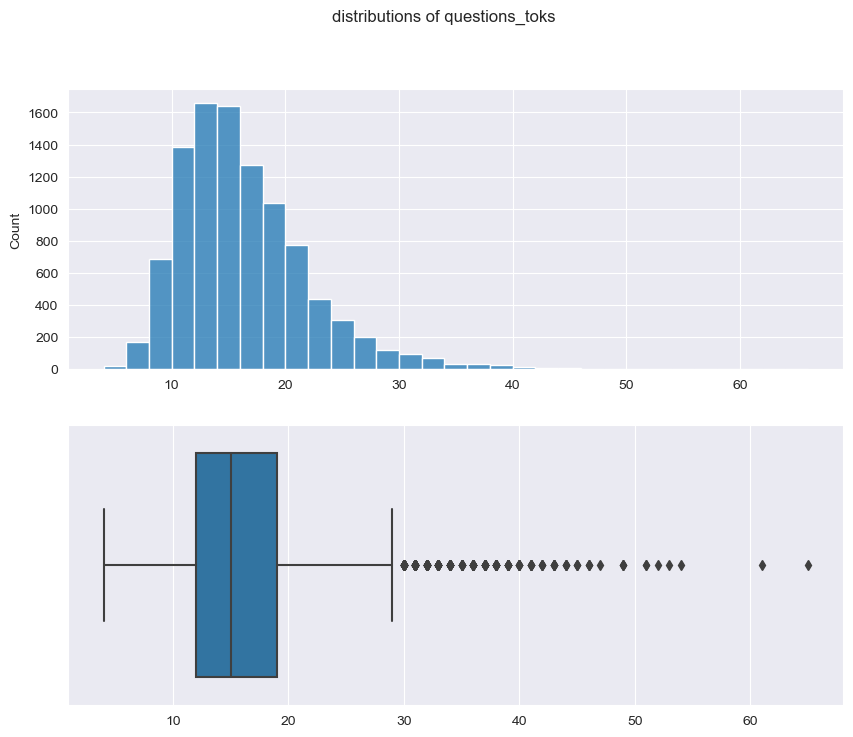

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["input_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["input_len"], ax=ax[1]);
fig.suptitle('distributions of inputs len');

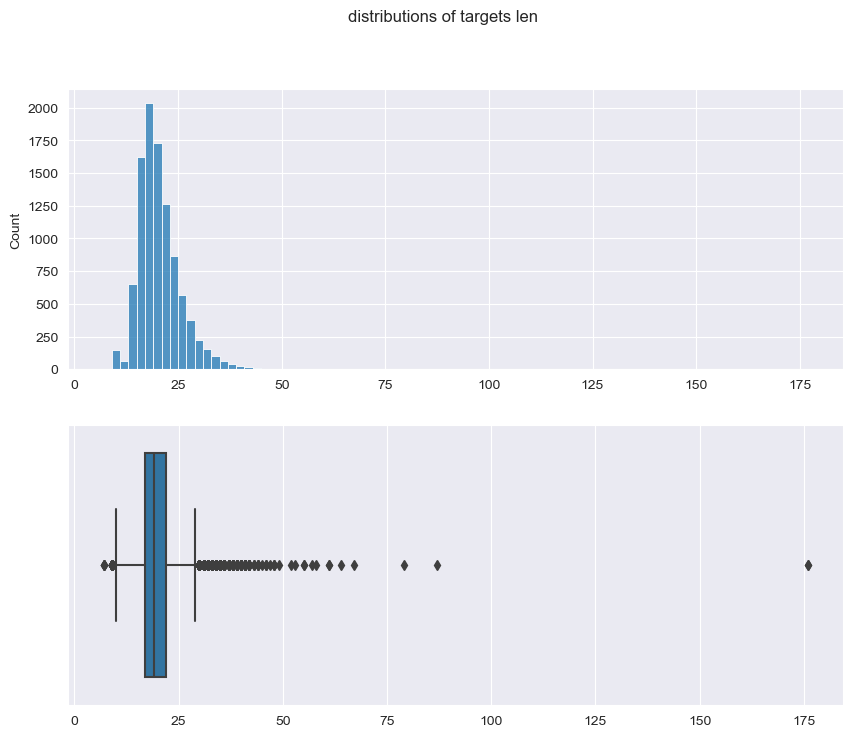

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["out_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["out_len"], ax=ax[1]);
fig.suptitle('distributions of targets len');

### Transformation

In [3]:
def format_dataset(example):
    return {'input': 'translate to SQL: ' + example['question'], 'target': example['sql']['human_readable']}

In [4]:
train_data = train_dataset.map(format_dataset, remove_columns=train_dataset.column_names)
test_data = test_dataset.map(format_dataset, remove_columns=test_dataset.column_names)

Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\wikisql\default\0.1.0\7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d\cache-b8662c973d31d87a.arrow
Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\wikisql\default\0.1.0\7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d\cache-27c564235b8b4412.arrow


### Tokenization

In [6]:
# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input'], pad_to_max_length=True, max_length=64)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target'], pad_to_max_length=True, max_length=64)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids'],
        'decoder_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [7]:
train_data = train_data.map(convert_to_features, batched=True, remove_columns=train_data.column_names)
test_data = test_data.map(convert_to_features, batched=True, remove_columns=test_data.column_names)

columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']

train_data.set_format(type='torch', columns=columns)
test_data.set_format(type='torch', columns=columns)

Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\wikisql\default\0.1.0\7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d\cache-d25356d38c7cb6b5.arrow
Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\wikisql\default\0.1.0\7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d\cache-7d80b92686cca44f.arrow


## Model Training

In [8]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

### Trainer Args

In [9]:
# set training arguments - Feel free to adapt it
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_base_finetuned_wikisql",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=500,
    save_strategy="epoch",
    #save_steps=1000,
    #eval_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    load_best_model_at_end=True,
    push_to_hub=False
    #fp16=True, 
)

### Metrics

In [10]:
from datasets import load_metric
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

C:\Users\Huang\AppData\Local\Temp\ipykernel_640\3190919124.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


### Trainer

In [11]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)

In [12]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 10.847341537475586,
 'eval_rouge2_precision': 0.088,
 'eval_rouge2_recall': 0.0886,
 'eval_rouge2_fmeasure': 0.087,
 'eval_runtime': 427.8238,
 'eval_samples_per_second': 37.113,
 'eval_steps_per_second': 2.321}

In [13]:
trainer.train()

c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 64776
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20245
  Number of trainable parameters = 222903552


  0%|          | 0/20245 [00:00<?, ?it/s]

{'loss': 0.4117, 'learning_rate': 4.8765127191899237e-05, 'epoch': 0.12}
{'loss': 0.1664, 'learning_rate': 4.753025438379847e-05, 'epoch': 0.25}
{'loss': 0.1504, 'learning_rate': 4.6295381575697705e-05, 'epoch': 0.37}
{'loss': 0.1369, 'learning_rate': 4.506050876759694e-05, 'epoch': 0.49}
{'loss': 0.1303, 'learning_rate': 4.382563595949617e-05, 'epoch': 0.62}
{'loss': 0.1246, 'learning_rate': 4.259076315139541e-05, 'epoch': 0.74}
{'loss': 0.1201, 'learning_rate': 4.135589034329465e-05, 'epoch': 0.86}
{'loss': 0.1179, 'learning_rate': 4.0121017535193876e-05, 'epoch': 0.99}


***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.09856275469064713, 'eval_rouge2_precision': 0.8357, 'eval_rouge2_recall': 0.7445, 'eval_rouge2_fmeasure': 0.7803, 'eval_runtime': 439.4601, 'eval_samples_per_second': 36.131, 'eval_steps_per_second': 2.26, 'epoch': 1.0}


Model weights saved in t5_base_finetuned_wikisql\checkpoint-4049\pytorch_model.bin


{'loss': 0.1072, 'learning_rate': 3.888614472709311e-05, 'epoch': 1.11}
{'loss': 0.1041, 'learning_rate': 3.765127191899235e-05, 'epoch': 1.23}
{'loss': 0.102, 'learning_rate': 3.641639911089158e-05, 'epoch': 1.36}
{'loss': 0.1005, 'learning_rate': 3.518152630279081e-05, 'epoch': 1.48}
{'loss': 0.1, 'learning_rate': 3.394665349469005e-05, 'epoch': 1.61}
{'loss': 0.0996, 'learning_rate': 3.271178068658928e-05, 'epoch': 1.73}
{'loss': 0.0968, 'learning_rate': 3.1476907878488515e-05, 'epoch': 1.85}
{'loss': 0.0963, 'learning_rate': 3.0242035070387752e-05, 'epoch': 1.98}


***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.08843619376420975, 'eval_rouge2_precision': 0.8458, 'eval_rouge2_recall': 0.754, 'eval_rouge2_fmeasure': 0.7901, 'eval_runtime': 428.5545, 'eval_samples_per_second': 37.05, 'eval_steps_per_second': 2.317, 'epoch': 2.0}


Model weights saved in t5_base_finetuned_wikisql\checkpoint-8098\pytorch_model.bin


{'loss': 0.0875, 'learning_rate': 2.9007162262286986e-05, 'epoch': 2.1}
{'loss': 0.0868, 'learning_rate': 2.7772289454186217e-05, 'epoch': 2.22}
{'loss': 0.0877, 'learning_rate': 2.6537416646085454e-05, 'epoch': 2.35}
{'loss': 0.0848, 'learning_rate': 2.530254383798469e-05, 'epoch': 2.47}
{'loss': 0.0857, 'learning_rate': 2.4067671029883923e-05, 'epoch': 2.59}
{'loss': 0.0854, 'learning_rate': 2.2832798221783157e-05, 'epoch': 2.72}
{'loss': 0.0862, 'learning_rate': 2.159792541368239e-05, 'epoch': 2.84}
{'loss': 0.0845, 'learning_rate': 2.0363052605581625e-05, 'epoch': 2.96}


***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.0853811651468277, 'eval_rouge2_precision': 0.8496, 'eval_rouge2_recall': 0.7573, 'eval_rouge2_fmeasure': 0.7937, 'eval_runtime': 434.8504, 'eval_samples_per_second': 36.514, 'eval_steps_per_second': 2.284, 'epoch': 3.0}


Model weights saved in t5_base_finetuned_wikisql\checkpoint-12147\pytorch_model.bin


{'loss': 0.0811, 'learning_rate': 1.912817979748086e-05, 'epoch': 3.09}
{'loss': 0.0781, 'learning_rate': 1.7893306989380097e-05, 'epoch': 3.21}
{'loss': 0.0784, 'learning_rate': 1.6658434181279328e-05, 'epoch': 3.33}
{'loss': 0.0764, 'learning_rate': 1.5423561373178562e-05, 'epoch': 3.46}
{'loss': 0.0764, 'learning_rate': 1.41886885650778e-05, 'epoch': 3.58}
{'loss': 0.0764, 'learning_rate': 1.295381575697703e-05, 'epoch': 3.7}
{'loss': 0.0786, 'learning_rate': 1.1718942948876266e-05, 'epoch': 3.83}
{'loss': 0.0767, 'learning_rate': 1.0484070140775502e-05, 'epoch': 3.95}


***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.08302274346351624, 'eval_rouge2_precision': 0.8516, 'eval_rouge2_recall': 0.7606, 'eval_rouge2_fmeasure': 0.7964, 'eval_runtime': 434.4033, 'eval_samples_per_second': 36.551, 'eval_steps_per_second': 2.286, 'epoch': 4.0}


Model weights saved in t5_base_finetuned_wikisql\checkpoint-16196\pytorch_model.bin
Deleting older checkpoint [t5_base_finetuned_wikisql\checkpoint-4049] due to args.save_total_limit


{'loss': 0.0727, 'learning_rate': 9.249197332674734e-06, 'epoch': 4.08}
{'loss': 0.0723, 'learning_rate': 8.01432452457397e-06, 'epoch': 4.2}
{'loss': 0.0747, 'learning_rate': 6.779451716473203e-06, 'epoch': 4.32}
{'loss': 0.0722, 'learning_rate': 5.544578908372438e-06, 'epoch': 4.45}
{'loss': 0.0738, 'learning_rate': 4.309706100271672e-06, 'epoch': 4.57}
{'loss': 0.0734, 'learning_rate': 3.0748332921709065e-06, 'epoch': 4.69}
{'loss': 0.0701, 'learning_rate': 1.8399604840701409e-06, 'epoch': 4.82}
{'loss': 0.0739, 'learning_rate': 6.050876759693752e-07, 'epoch': 4.94}


***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/993 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.08280162513256073, 'eval_rouge2_precision': 0.8536, 'eval_rouge2_recall': 0.7618, 'eval_rouge2_fmeasure': 0.798, 'eval_runtime': 431.9356, 'eval_samples_per_second': 36.76, 'eval_steps_per_second': 2.299, 'epoch': 5.0}


Model weights saved in t5_base_finetuned_wikisql\checkpoint-20245\pytorch_model.bin
Deleting older checkpoint [t5_base_finetuned_wikisql\checkpoint-8098] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from t5_base_finetuned_wikisql\checkpoint-20245 (score: 0.08280162513256073).


{'train_runtime': 7332.0264, 'train_samples_per_second': 44.173, 'train_steps_per_second': 2.761, 'train_loss': 0.10108991412358038, 'epoch': 5.0}


TrainOutput(global_step=20245, training_loss=0.10108991412358038, metrics={'train_runtime': 7332.0264, 'train_samples_per_second': 44.173, 'train_steps_per_second': 2.761, 'train_loss': 0.10108991412358038, 'epoch': 5.0})

In [14]:
trainer.save_model()

Saving model checkpoint to t5_base_finetuned_wikisql
Configuration saved in t5_base_finetuned_wikisql\config.json
Configuration saved in t5_base_finetuned_wikisql\generation_config.json
Model weights saved in t5_base_finetuned_wikisql\pytorch_model.bin


In [17]:
tokenizer.save_pretrained('t5_base_finetuned_wikisql')

tokenizer config file saved in t5_base_finetuned_wikisql\tokenizer_config.json
Special tokens file saved in t5_base_finetuned_wikisql\special_tokens_map.json
Copy vocab file to t5_base_finetuned_wikisql\spiece.model


('t5_base_finetuned_wikisql\\tokenizer_config.json',
 't5_base_finetuned_wikisql\\special_tokens_map.json',
 't5_base_finetuned_wikisql\\spiece.model',
 't5_base_finetuned_wikisql\\added_tokens.json',
 't5_base_finetuned_wikisql\\tokenizer.json')

## Model Inference on WikiSQL Test Set

### Fine Tuned Model

In [24]:
CKPT = 't5_base_finetuned_wikisql'
model_tuned = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer_tuned = AutoTokenizer.from_pretrained(CKPT)

loading configuration file t5_base_finetuned_wikisql\config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "ea

### Inference Set

In [26]:
inference_data = load_dataset('wikisql', split='test')

In [29]:
def translate_to_sql(text, tokenizer, model):
    inputs = tokenizer(text, padding='longest', max_length=64, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=64)

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [30]:
for i in range(0,100,10):
    print('translate to SQL: ' + inference_data[i]['question'])
    print('Predict. :' + translate_to_sql('translate to SQL: ' + inference_data[i]['question'], tokenizer=tokenizer_tuned, model=model_tuned))
    print('Expected: ' + inference_data[i]['sql']['human_readable'])
    print('=================================\n')
     

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



translate to SQL: What is terrence ross' nationality


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Nationality FROM table WHERE Player = Terrence Ross
Expected: SELECT Nationality FROM table WHERE Player = Terrence Ross

translate to SQL: How many different nationalities do the players of New Jersey Devils come from?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT COUNT Nationality FROM table WHERE NHL team = New Jersey Devils
Expected: SELECT COUNT Nationality FROM table WHERE NHL team = New Jersey Devils

translate to SQL: If you are a pilot officer in the commonwealth then what will you called as in the US air force?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT US Air Force FROM table WHERE Position = Pilot Officer AND Country = Commonwealth
Expected: SELECT US Air Force equivalent FROM table WHERE Commonwealth equivalent = Pilot Officer

translate to SQL: what is the total number of total w–l where doubles w–l is 11–11


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11
Expected: SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11

translate to SQL: Which Frequency is used for WEGP calls?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Frequency FROM table WHERE Caller ID = wepg
Expected: SELECT Frequency FROM table WHERE Calls = WEGP

translate to SQL: If a radius is 10, what  is the lowest possible mass?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT MIN Mass FROM table WHERE Radius = 10
Expected: SELECT MIN Mass (M ☉ ) FROM table WHERE Radius (R ☉ ) = 10

translate to SQL: what's the new south wales with crop (kilotonnes) being canola


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT New South Wales FROM table WHERE Crop (kilotonnes) = Canola
Expected: SELECT New South Wales FROM table WHERE Crop (kilotonnes) = Canola

translate to SQL: If % lunsford is 51.82% what is the % mcconnell in Letcher?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Letcher FROM table WHERE % Lunsford = 51.82%
Expected: SELECT % McConnell FROM table WHERE % Lunsford = 51.82%

translate to SQL: What is the percentage of the Shivalik Zone where the percentage of the Mid-Hill Zone is 10%?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Shivalik Zone FROM table WHERE Mid-Hill Zone = 10%
Expected: SELECT Shivalik Zone FROM table WHERE Mid-Hill Zone = 10%

translate to SQL: How many episodes in season 6 titles "Poppin' Tags"?
Predict. :SELECT COUNT No. in season FROM table WHERE Title = "Poppin' Tags"
Expected: SELECT COUNT No. in season FROM table WHERE Title = "Poppin' Tags"



## Model Inference on CoSQL